# Adaptive PDE discretizations on cartesian grids 
## Volume : Reproducible research
## Part : Eikonal CPU/GPU solvers comparison
## Chapter : Five dimensional Reeds-Shepp models

In this chapter, we consider generalized Reeds-Shepp models, in the five dimensional domain $R^3 \times S^2$. The models are described in more detail in the notebook [Curvature3](../Notebooks_FMM/Curvature3.ipynb), and may in principle be used to segment three dimensional data such as white fiber tracks in MRI scans of the brain, or plan the motion of aerial vehicles.
This notebook presents GPU accelerated solvers of these models, which have a good potential in view of the high dimensionality ($d=5$) of the state space.

A significant difference between the CPU and GPU implementations is the treatment of the sphere topology. 
* The CPU implementation relies on angular coordinates $(\theta,\phi)$. The resulting metric on the sphere is diagonal. The main weakness of this approach is the treatment of the poles, where the parametrization is singular reverses its orientation.
* The GPU implementation relies on the equatorial projection. The resulting metric on the sphere is isotropic. Memory usage is one of the weaknesses of this approach, this a band of values is stored twice along the equator, and some parts of the parametrization domain are unused.

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"../..")
#from Miscellaneous import TocTools; print(TocTools.displayTOC('Flow_GPU','Repro'))

In [2]:
from agd import Eikonal
from agd import AutomaticDifferentiation as ad
from agd import FiniteDifferences as fd
from agd import Metrics
from agd import LinearParallel as lp
norm = ad.Optimization.norm
from agd.Plotting import savefig, SetTitle3D; #savefig.dirName = 'Figures/Curvature3_GPU/'

In [3]:
import numpy as np; xp=np; allclose = np.allclose
from matplotlib import pyplot as plt
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%5.3g" % x))

### 0.1 Additional configuration

The GPU accelerated eikonal solver is mandatory for this notebook.

In [4]:
if ad.cupy_generic.cp is None: raise ad.DeliberateNotebookError("cupy module not found")

In [5]:
xp,Eikonal,plt,allclose = [ad.cupy_friendly(e) for e in (xp,Eikonal,plt,allclose)]

Replacing numpy with cupy, set to output 32bit ints and floats by default.
Using cp.asarray(*,dtype=np.float32) as the default caster in ad.array.
Setting dictIn.default_mode = 'gpu' in module agd.Eikonal .
Returning a copy of module matplotlib.pyplot whose functions accept cupy arrays as input.
Setting float32 compatible default values atol=rtol=1e-5 in np.allclose


## 1. Space discretization

In [14]:
n=50 
hfmIn = Eikonal.dictIn({
    'model':'ReedsSheppGPU3',
    'cost':1.,
    'seed':[0,0,0,0,0],
    
    # Define euclidean geometry on R^3 x S^2, for illustration
    'eps':1,
    'xi':1,
    'traits':{'decomp_v_align_macro':False},
    
    # Recompute flow at geodesic extraction
    'geodesic_online_flow':True,

#    'dual':True,
#    'forward':True,    
})
hfmIn.SetRect([[-1,1],[-1,1],[-1,1]],dimx=n)
transformations = hfmIn.SetSphere(dimsp=32,separation=False) # projective model
hfmIn.SetUniformTips((3,3,3,3,3))

The HJB approach to optimal control is subject to the curse of dimensionality: the number of discretization points, hence of unknowns to the PDE, grows extremely quickly in dimension $5$.

In [15]:
hfmIn.size

128000000

The half-sphere is discretized using a cartesian grid in the equator plane, and a projection.

In [16]:
aS = hfmIn.Axes()[3:]
SGrid = ad.array(np.meshgrid(*aS,indexing='ij')) # cartesian grid of the equator
SPoints = transformations['to_sphere'](SGrid)

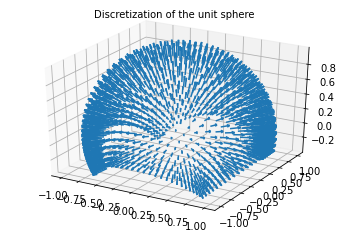

In [17]:
fig = plt.figure(); ax = fig.gca(projection='3d'); SetTitle3D(ax,"Discretization of the unit sphere")
plt.quiver(*SPoints,*SPoints,length=0.2);

In [18]:
hfmOut = hfmIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel


CompileException: C:\Users\Shadow\Documents\GitHub\AdaptiveGridDiscretizations\agd\Eikonal\HFM_CUDA\cuda\ReedsSheppGPU3.h(5): error: "dim3" has already been declared in the current scope

C:\Users\Shadow\Documents\GitHub\AdaptiveGridDiscretizations\agd\Eikonal\HFM_CUDA\cuda\ReedsSheppGPU3.h(47): error: identifier "mul_kvV" is undefined

C:\Users\Shadow\Documents\GitHub\AdaptiveGridDiscretizations\agd\Eikonal\HFM_CUDA\cuda\ReedsSheppGPU3.h(59): error: identifier "geom_size" is undefined

C:\Users\Shadow\Documents\GitHub\AdaptiveGridDiscretizations\agd\Eikonal\HFM_CUDA\cuda\ReedsSheppGPU3.h(63): error: identifier "conformal_cost" is undefined

C:\Users\Shadow\Documents\GitHub\AdaptiveGridDiscretizations\agd\Eikonal\HFM_CUDA\cuda\ReedsSheppGPU3.h(66): error: identifier "fill_kV" is undefined

C:\Users\Shadow\Documents\GitHub\AdaptiveGridDiscretizations\agd\Eikonal\HFM_CUDA\cuda\ReedsSheppGPU3.h(96): error: namespace "dim3" has no member "decomp_v"

C:\Users\Shadow\AppData\Local\Temp\tmpqvnd3e8o\91d59781f80a761b826a5b4bb05514e2_2.cubin.cu(9): warning: variable "shape_i" was declared but never referenced

C:\Users\Shadow\AppData\Local\Temp\tmpqvnd3e8o\91d59781f80a761b826a5b4bb05514e2_2.cubin.cu(11): warning: variable "niter_i" was declared but never referenced

C:\Users\Shadow\AppData\Local\Temp\tmpqvnd3e8o\91d59781f80a761b826a5b4bb05514e2_2.cubin.cu(23): warning: variable "size_i" was declared but never referenced

C:\Users\Shadow\AppData\Local\Temp\tmpqvnd3e8o\91d59781f80a761b826a5b4bb05514e2_2.cubin.cu(24): warning: variable "log2_size_i" was declared but never referenced

6 errors detected in the compilation of "C:\Users\Shadow\AppData\Local\Temp\tmpqvnd3e8o\91d59781f80a761b826a5b4bb05514e2_2.cubin.cu".
